In [ ]:
# 2009_2010 in the name of the file glorys12_surface_T_uv_2009_2010 is incorrect. This data is actually for 2020-2024
!cp /kaggle/input/glorys2/glorys12_surface_T_uv_2009_2010.nc /kaggle/working/glorys.nc 


# Predicting Surface Temperature with CNN, LSTM, and Diffusion Models

This notebook trains three forecasting tasks on the provided `glorys.nc` sample:

- **temp → temp**: predict the next sea-surface temperature map.
- **vel → vel**: predict the next horizontal velocity field with a zero-divergence penalty.
- **temp + vel → temp**: predict the next temperature conditioned on present temperature, present velocity, and the predicted next velocity.

A simple advection–diffusion baseline is also included. Hyperparameter search runs for three epochs per candidate; the best non-diffusion and diffusion models are then trained longer for comparison.


In [2]:

import math
import random
import numpy as np
import xarray as xr
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import gc
import matplotlib.pyplot as plt


SEED = 42
DATA_PATH = '/kaggle/input/glorys-2014-2024/glorys_2014_2024 (1).nc'
PRED_HORIZON = 7
SEARCH_EPOCHS = 30 # amount of epochs models are trained for just for hyperparam selection
NUM_EPOCHS = 100 # amount of epochs models are trained for after hyperparam selection
BATCH_SIZE = 4
DIFFUSION_STEPS = 10
ADVECTION_DT = 1
DIFFUSIVITY = 1e-3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameter grids
# Learning rates to try
TEMP_LRS = [1e-4, 3e-4, 1e-3]
VEL_LRS = [1e-4, 3e-4, 1e-3]
COMB_LRS = [1e-4, 3e-4, 1e-3]

# Divergence weights to try for vel models
DIV_WEIGHTS = [0.0, 1e-3, 1e-2]


torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


## 1. Load and prepare the GLORYS dataset

In [3]:
"""
STEP 1: Load GLORYS
"""

ds = xr.open_dataset(DATA_PATH)

# bigger subset for final project
ds = ds.isel(time=slice(0,1095),latitude=slice(200,200+256), longitude=slice(220,220+256))
ds = ds.coarsen(latitude=2, longitude=2, boundary="trim").mean()

# small subset for testing
# ds = ds.isel(time=slice(0,1095),latitude=slice(200,220), longitude=slice(50,70))
ds

<xarray.Dataset> Size: 11MB
Dimensions:    (time: 1095, depth: 1, latitude: 20, longitude: 20)
Coordinates:
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 80B 24.67 24.75 24.83 ... 26.08 26.17 26.25
  * longitude  (longitude) float32 80B -97.83 -97.75 -97.67 ... -96.33 -96.25
  * time       (time) datetime64[ns] 9kB 2014-12-12 2014-12-13 ... 2017-12-10
Data variables:
    thetao     (time, depth, latitude, longitude) float64 4MB ...
    uo         (time, depth, latitude, longitude) float64 4MB ...
    vo         (time, depth, latitude, longitude) float64 4MB ...
Attributes:
    references:                http://www.mercator-ocean.fr
    title:                     daily mean fields from Global Ocean Physics An...
    source:                    MERCATOR GLORYS12V1
    institution:               MERCATOR OCEAN
    Conventions:               CF-1.4
    comment:                   CMEMS product
    history:                   2023/06/01 16:20:05 MERCATOR OCEAN Netcdf crea...
    copernicusmarine_version:  2.2.5

In [4]:
"""
STEP 2: build a common NaN mask, and normalize using only valid ocean points.
"""

# ---- Raw data with NaNs kept ----
sea_temp_raw = ds["thetao"].isel(depth=0).values.astype(np.float32)  # (time, lat, lon)
u_field_raw  = ds["uo"].isel(depth=0).values.astype(np.float32)
v_field_raw  = ds["vo"].isel(depth=0).values.astype(np.float32)

# ---- Common validity mask: valid only where ALL three fields are finite ----
valid_3d = (
    np.isfinite(sea_temp_raw) &
    np.isfinite(u_field_raw) &
    np.isfinite(v_field_raw)
)  # shape: (time, lat, lon)

# require a grid cell to be valid for ALL selected times
valid_2d = valid_3d.all(axis=0).astype(np.float32)   # (lat, lon)

print("Total spatial pixels:", valid_2d.size)
print("Valid ocean pixels (common mask):", valid_2d.sum())

# Single global mask for everything: shape (1, 1, H, W)
VALID_MASK = torch.tensor(valid_2d, dtype=torch.float32, device=DEVICE).unsqueeze(0).unsqueeze(0)

# ---- Fill NaNs for model inputs (we'll still mask them in loss) ----
sea_temp = np.nan_to_num(sea_temp_raw, nan=0.0, posinf=0.0, neginf=0.0)
u_field  = np.nan_to_num(u_field_raw,  nan=0.0, posinf=0.0, neginf=0.0)
v_field  = np.nan_to_num(v_field_raw,  nan=0.0, posinf=0.0, neginf=0.0)

# ---- Compute statistics using ONLY valid ocean points ----
temp_mean = sea_temp_raw[valid_3d].mean()
temp_std  = sea_temp_raw[valid_3d].std() + 1e-6

vel_stack = np.stack([u_field_raw, v_field_raw], axis=0)  # (2, time, lat, lon)
vel_valid = np.isfinite(vel_stack) & np.broadcast_to(valid_3d, vel_stack.shape)
vel_mean  = vel_stack[vel_valid].mean()
vel_std   = vel_stack[vel_valid].std() + 1e-6

print("temp_mean, temp_std:", float(temp_mean), float(temp_std))
print("vel_mean, vel_std:", float(vel_mean), float(vel_std))

# ---- Normalize inputs ----
sea_temp_norm = (sea_temp - temp_mean) / temp_std
u_norm        = (u_field - vel_mean) / vel_std
v_norm        = (v_field - vel_mean) / vel_std

num_times, lat_count, lon_count = sea_temp_norm.shape
print("Normalized shapes:", sea_temp_norm.shape)


Total spatial pixels: 400
Valid ocean pixels (common mask): 278.0
temp_mean, temp_std: 25.703086853027344 3.398188875747681
vel_mean, vel_std: 0.020655041560530663 0.18353405757045746
Normalized shapes: (1095, 20, 20)


In [ ]:
'''
This code was used to check that the nan-mask is almost the same for temp and vel arrays for all t.
This allows us to use the same 2d nan mask.
'''

'''
import xarray as xr
import numpy as np

# Point this to your big file, e.g.:
# DATA_PATH = "glorys.nc"
ds = xr.open_dataset(DATA_PATH)

num_times = ds.dims["time"]
chunk_size = 8   # adjust if you want, this keeps memory small

diff_3d = 0                  # how many (t,lat,lon) points differ
temp_mask_2d = None          # will hold "valid at all times" for temp
vel_mask_2d = None           # same for velocity

for start in range(0, num_times, chunk_size):
    end = min(start + chunk_size, num_times)
    print(f"Processing time indices [{start}:{end})")

    # Load a small time chunk into memory
    temp_chunk = ds["thetao"].isel(depth=0, time=slice(start, end)).values  # (chunk, lat, lon)
    u_chunk    = ds["uo"].isel(depth=0, time=slice(start, end)).values
    v_chunk    = ds["vo"].isel(depth=0, time=slice(start, end)).values

    # Finite-value masks for this chunk
    temp_mask_chunk = np.isfinite(temp_chunk)
    vel_mask_chunk  = np.isfinite(u_chunk) & np.isfinite(v_chunk)

    # --- 3D comparison for this chunk ---
    diff_3d += np.count_nonzero(temp_mask_chunk != vel_mask_chunk)

    # --- Update 2D "valid for all times" masks ---
    # For this chunk, a cell is valid if it's valid at every time in the chunk
    temp_mask_2d_chunk = temp_mask_chunk.all(axis=0)   # (lat, lon)
    vel_mask_2d_chunk  = vel_mask_chunk.all(axis=0)

    if temp_mask_2d is None:
        # First chunk: initialize with this chunk's "all times" mask
        temp_mask_2d = temp_mask_2d_chunk
        vel_mask_2d  = vel_mask_2d_chunk
    else:
        # Later chunks: must also be valid in all previous chunks
        temp_mask_2d &= temp_mask_2d_chunk
        vel_mask_2d  &= vel_mask_2d_chunk

# After streaming through all time chunks:
same_3d = (diff_3d == 0)
same_2d = np.array_equal(temp_mask_2d, vel_mask_2d)
diff_2d = np.count_nonzero(temp_mask_2d != vel_mask_2d)

print("Do temp and vel masks match at every (t,lat,lon)?", same_3d)
print("Number of differing points in full 3D mask:", diff_3d)
print("Do temp and vel masks match as 2D spatial masks?", same_2d)
print("Number of differing pixels in 2D mask:", diff_2d)
print("Total valid ocean pixels (2D) in temp:", temp_mask_2d.sum())
print("Total valid ocean pixels (2D) in vel:", vel_mask_2d.sum())
'''

### Train/validation/test splits
We build paired samples with a PRED_HORIZON step horizon.

In [5]:
# sea_temp_norm, u_norm, v_norm: shapes (T, H, W)
num_times = sea_temp_norm.shape[0]

# We want pairs of the form:
#   input:  [temp(t-1), temp(t)]         (2, H, W)
#   output: temp(t + PRED_HORIZON)       (1, H, W)
# with t running from 1 .. num_times - PRED_HORIZON - 1

# Build temp_in with 2 snapshots
temp_in = torch.tensor(
    np.stack(
        [sea_temp_norm[0:-PRED_HORIZON-1],  # temp at t-1
         sea_temp_norm[1:-PRED_HORIZON]],    # temp at t
        axis=1,  # stack along channel dim -> (N, 2, H, W)
    ),
    dtype=torch.float32,
)

# Build temp_out
temp_out = torch.tensor(sea_temp_norm[PRED_HORIZON + 1:], dtype=torch.float32).unsqueeze(1)  # (N, 1, H, W)


# vel → vel pairs (two channels): vel(t) → vel(t + PRED_HORIZON)
vel_in = torch.tensor(np.stack([u_norm[:-PRED_HORIZON], v_norm[:-PRED_HORIZON]], axis=1), dtype=torch.float32)  # (pairs, 2, H, W)

vel_out = torch.tensor(np.stack([u_norm[PRED_HORIZON:], v_norm[PRED_HORIZON:]], axis=1), dtype=torch.float32)  # (pairs, 2, H, W)


# Number of (input, output) pairs is now:
pairs = temp_in.shape[0]

train_count = int(pairs * 0.7)
val_count   = int(pairs * 0.15)

train_idx = slice(0, train_count)
val_idx   = slice(train_count, train_count + val_count)
test_idx  = slice(train_count + val_count, pairs)
print('Prediction horizon (steps):', PRED_HORIZON)
print('Temp pair shape', temp_in.shape, temp_out.shape)  # (N, 2, H, W), (N, 1, H, W)
print('Vel pair shape', vel_in.shape, vel_out.shape)      # (N, 2, H, W), (N, 2, H, W)




Prediction horizon (steps): 7
Temp pair shape torch.Size([1087, 2, 20, 20]) torch.Size([1087, 1, 20, 20])
Vel pair shape torch.Size([1088, 2, 20, 20]) torch.Size([1088, 2, 20, 20])


### Data loaders

In [6]:

temp_train = TensorDataset(temp_in[train_idx], temp_out[train_idx])
temp_val   = TensorDataset(temp_in[val_idx],  temp_out[val_idx])
temp_test  = TensorDataset(temp_in[test_idx], temp_out[test_idx])

vel_train = TensorDataset(vel_in[train_idx], vel_out[train_idx])
vel_val   = TensorDataset(vel_in[val_idx],   vel_out[val_idx])
vel_test  = TensorDataset(vel_in[test_idx],  vel_out[test_idx])

loader_temp_train = DataLoader(temp_train, batch_size=BATCH_SIZE, shuffle=True)
loader_temp_val = DataLoader(temp_val, batch_size=BATCH_SIZE)
loader_temp_test = DataLoader(temp_test, batch_size=BATCH_SIZE)

loader_vel_train = DataLoader(vel_train, batch_size=BATCH_SIZE, shuffle=True)
loader_vel_val = DataLoader(vel_val, batch_size=BATCH_SIZE)
loader_vel_test = DataLoader(vel_test, batch_size=BATCH_SIZE)


## 2. Utilities: RMSE, divergence penalty, and simple models

In [7]:
def temp_loss(pred, target):
    """
    Loss for temperature models: MSE over valid ocean points.
    pred, target: (B, 1, H, W)
    """
    diff2 = (pred - target) ** 2
    diff2 = diff2 * VALID_MASK
    return diff2.sum() / VALID_MASK.sum()


def vel_loss(pred, target, div_weight):
    """
    Loss for velocity models: MSE over valid ocean points
    + divergence penalty on the PREDICTED velocity.
    pred, target: (B, 2, H, W)
    """
    diff2 = (pred - target) ** 2
    diff2 = diff2 * VALID_MASK
    mse_term = diff2.sum() / VALID_MASK.sum()

    div_sq = (divergence(pred) ** 2) * VALID_MASK  # (B,H,W) * (1,1,H,W) -> (B,1,H,W)
    div_term = div_sq.sum() / VALID_MASK.sum()

    return mse_term + div_weight * div_term


BETAS = torch.linspace(1e-4, 0.02, DIFFUSION_STEPS, device=DEVICE)
ALPHAS = 1.0 - BETAS
ALPHAS_CUMPROD = torch.cumprod(ALPHAS, dim=0)

SQRT_ALPHAS_CUMPROD = torch.sqrt(ALPHAS_CUMPROD)             # sqrt(ᾱ_t)
SQRT_ONE_MINUS_ALPHAS_CUMPROD = torch.sqrt(1.0 - ALPHAS_CUMPROD)  # sqrt(1 - ᾱ_t)

def diffusion_loss_temp(model, cond, target):
    """
    Diffusion loss for temperature:
    predict noise ε at random timestep t, masked over VALID_MASK.
    cond:   (B, C_cond, H, W)  – conditioning (e.g., temp at t, or temp+vel)
    target: (B, 1, H, W)       – temp at t+HORIZON
    """
    b = target.size(0)
    device = target.device

    # Sample timesteps
    t = torch.randint(0, DIFFUSION_STEPS, (b,), device=device)

    # Pick precomputed schedule values for those timesteps
    sqrt_ac = SQRT_ALPHAS_CUMPROD[t].view(b, 1, 1, 1)              # √ᾱ_t
    sqrt_om = SQRT_ONE_MINUS_ALPHAS_CUMPROD[t].view(b, 1, 1, 1)    # √(1 - ᾱ_t)

    noise = torch.randn_like(target)
    x_noisy = sqrt_ac * target + sqrt_om * noise

    t_embed = t.float() / DIFFUSION_STEPS

    inp = torch.cat([cond, x_noisy], dim=1)
    eps = model(inp, t_embed)  # same shape as target

    diff2 = (eps - noise) ** 2
    diff2 = diff2 * VALID_MASK
    return diff2.sum() / VALID_MASK.sum()


def diffusion_loss_vel(model, cond, target, div_weight):
    """
    Diffusion loss for velocity:
    - masked noise prediction loss
    - + divergence penalty on the predicted clean velocity field.
    cond:   (B, C_cond, H, W)
    target: (B, 2, H, W)
    """
    b = target.size(0)
    device = target.device

    t = torch.randint(0, DIFFUSION_STEPS, (b,), device=device)

    sqrt_ac = SQRT_ALPHAS_CUMPROD[t].view(b, 1, 1, 1)
    sqrt_om = SQRT_ONE_MINUS_ALPHAS_CUMPROD[t].view(b, 1, 1, 1)

    noise = torch.randn_like(target)
    x_noisy = sqrt_ac * target + sqrt_om * noise

    t_embed = t.float() / DIFFUSION_STEPS

    inp = torch.cat([cond, x_noisy], dim=1)
    eps = model(inp, t_embed)  # predicted noise

    # 1) noise-prediction loss
    diff2 = (eps - noise) ** 2
    diff2 = diff2 * VALID_MASK
    loss_eps = diff2.sum() / VALID_MASK.sum()

    # 2) reconstruct x0 and penalize divergence
    x0_pred = (x_noisy - sqrt_om * eps) / (sqrt_ac + 1e-8)

    div_sq = (divergence(x0_pred) ** 2) * VALID_MASK
    loss_div = div_sq.sum() / VALID_MASK.sum()

    return loss_eps + div_weight * loss_div



# not used for hyperparam search, just for final reporting
def rmse(pred, target):
    """
    pred, target: (B, C, H, W) or (1, C, H, W)
    Computes RMSE over all valid ocean points and all samples in the batch.
    """
    diff2 = (pred - target) ** 2
    diff2 = diff2 * VALID_MASK  # broadcast over batch

    # number of valid pixels per sample
    pixels_per_sample = VALID_MASK.sum()

    # total valid points across the batch
    total_points = pixels_per_sample * pred.size(0)

    return torch.sqrt(diff2.sum() / total_points).item()


def divergence(field):
    u = field[:, 0]
    v = field[:, 1]
    du_dx = u[:, :, 2:] - u[:, :, :-2]
    dv_dy = v[:, 2:, :] - v[:, :-2, :]
    du_dx = torch.nn.functional.pad(du_dx, (1, 1, 0, 0))
    dv_dy = torch.nn.functional.pad(dv_dy, (0, 0, 1, 1))
    return du_dx + dv_dy


In [8]:

class SimpleCNN(nn.Module):
    def __init__(self, in_channels, out_channels, hidden=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, hidden, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden, hidden, 3, padding=1),
            nn.ReLU(),
            #Optional layer
            #nn.Conv2d(hidden, hidden, 3, padding=1),
            #nn.ReLU(),
            nn.Conv2d(hidden, out_channels, 3, padding=1)
        )

    def forward(self, x):
        return self.net(x)


class SimpleLSTM(nn.Module):
    def __init__(self, in_channels, out_channels, hidden=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=in_channels,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
        )
        self.head = nn.Linear(hidden, out_channels)


    def forward(self, x):
        b, c, h, w = x.shape
        seq = x.permute(0, 2, 3, 1).reshape(b, h * w, c).contiguous()
        out, _ = self.lstm(seq)
        out = self.head(out)
        out = out.reshape(b, h, w, -1).permute(0, 3, 1, 2)
        return out


class DiffusionUNet(nn.Module):
    def __init__(self, in_channels, out_channels, hidden=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels + 1, hidden, 3, padding=1)
        self.conv2 = nn.Conv2d(hidden, hidden, 3, padding=1)
        self.conv3 = nn.Conv2d(hidden, out_channels, 3, padding=1)
        self.act = nn.ReLU()

    def forward(self, x, t_embed):
        t = t_embed[:, None, None, None]
        xt = torch.cat([x, t.expand(x.size(0), 1, x.size(2), x.size(3))], dim=1)
        h1 = self.act(self.conv1(xt))
        h2 = self.act(self.conv2(h1))
        return self.conv3(h2)


In [10]:


# take 2 temp snapshots and output 1 temp snapshot prediction PRED_HORIZON days in future
#un comment codes you need to train
temp_candidates = [
    ('cnn16', lambda: SimpleCNN(2, 1, hidden=16)),
    ('cnn32', lambda: SimpleCNN(2, 1, hidden=32)),
    ('cnn64', lambda: SimpleCNN(2, 1, hidden=64)),
    # ('lstm32_1L', lambda: SimpleLSTM(2, 1, hidden=32, num_layers=1)),
    # ('lstm32_2L', lambda: SimpleLSTM(2, 1, hidden=32, num_layers=2)),
    # ('lstm64_1L', lambda: SimpleLSTM(2, 1, hidden=64, num_layers=1)),
    # ('lstm64_2L', lambda: SimpleLSTM(2, 1, hidden=64, num_layers=2)),
    # ('lstm128_1L', lambda: SimpleLSTM(2, 1, hidden=128, num_layers=1)),
    # ('lstm128_2L', lambda: SimpleLSTM(2, 1, hidden=128, num_layers=2)),
]
# take 1 vel snapshot and output 1 vel snapshot prediction PRED_HORIZON days in future
vel_candidates = [
    ('cnn16', lambda: SimpleCNN(2, 2, hidden=16)),
    ('cnn32', lambda: SimpleCNN(2, 2, hidden=32)),
    # ('cnn64', lambda: SimpleCNN(2, 2, hidden=64)),
    # ('lstm32_1L', lambda: SimpleLSTM(2, 2, hidden=32, num_layers=1)),
    # ('lstm32_2L', lambda: SimpleLSTM(2, 2, hidden=32, num_layers=2)),
    # ('lstm64_1L', lambda: SimpleLSTM(2, 2, hidden=64, num_layers=1)),
    # ('lstm64_2L', lambda: SimpleLSTM(2, 2, hidden=64, num_layers=2)),
    # ('lstm128_1L', lambda: SimpleLSTM(2, 2, hidden=128, num_layers=1)),
    # ('lstm128_2L', lambda: SimpleLSTM(2, 2, hidden=128, num_layers=2)),
]
# take 2 temp snapshots, 1 vel snapshot, and 1 predicted vel snapshot and output 1 temp snapshot prediction PRED_HORIZON days in future
comb_candidates = [
    ('cnn24', lambda: SimpleCNN(6, 1, hidden=24)),
    ('cnn48', lambda: SimpleCNN(6, 1, hidden=48)),
    ('cnn96', lambda: SimpleCNN(6, 1, hidden=96)),
    # ('lstm96_1L', lambda: SimpleLSTM(6, 1, hidden=96,num_layers=1)),
    # ('lstm96_2L', lambda: SimpleLSTM(6, 1, hidden=96,num_layers=2)),
    # ('lstm48_1L', lambda: SimpleLSTM(6, 1, hidden=48,num_layers=1)),
    # ('lstm96_2L', lambda: SimpleLSTM(6, 1, hidden=96,num_layers=2)),
]



temp_diff_candidates = [
    ('diffusion32', lambda: DiffusionUNet(in_channels=3, out_channels=1, hidden=32)),
]
vel_diff_candidates = [
    ('diffusion32', lambda: DiffusionUNet(in_channels=4, out_channels=2, hidden=32)),
]
comb_diff_candidates = [
    ('diffusion48', lambda: DiffusionUNet(in_channels=7, out_channels=1, hidden=48)),
]

### Training helpers

In [11]:
def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0.0
    for xin, y in loader:
        xin = xin.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad()
        pred = model(xin)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def train_epoch_diffusion(model, loader, optimizer, diffusion_loss_fn):
    """
    Same idea as train_epoch, but for diffusion models where the loss
    needs access to (model, xin, y) instead of just (pred, y).
    """
    model.train()
    total_loss = 0.0
    for xin, y in loader:
        xin = xin.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad()
        loss = diffusion_loss_fn(model, xin, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

def train_epoch_vel(model, loader, optimizer, div_weight: float):
    model.train()
    total_loss = 0.0
    for xin, y in loader:
        xin = xin.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad()
        preds = model(xin)
        loss = vel_loss(preds, y, div_weight)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)


def train_epoch_diffusion_vel(model, loader, optimizer, div_weight: float):
    model.train()
    total_loss = 0.0
    for xin, y in loader:
        xin = xin.to(DEVICE)
        y = y.to(DEVICE)

        optimizer.zero_grad()
        loss = diffusion_loss_vel(model, xin, y, div_weight)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad
def evaluate_model(model, loader, diffusion=False, out_channels=1):
    model.eval()
    rmses = []
    for xin, y in loader:
        xin = xin.to(DEVICE)
        y = y.to(DEVICE)
        if diffusion:
            preds = diffusion_sample(model, xin, out_channels=out_channels)
        else:
            preds = model(xin)
        rmses.append(rmse(preds, y))  # uses global VALID_MASK
    return sum(rmses) / len(rmses)


### Diffusion helpers

In [12]:
@torch.no_grad
def diffusion_sample(model, cond, out_channels):
    model.eval()
    b, _, H, W = cond.shape
    x = torch.randn(b, out_channels, H, W, device=cond.device)

    for i in reversed(range(DIFFUSION_STEPS)):
        t = torch.full((b,), i, device=cond.device, dtype=torch.long)
        t_embed = t.float() / DIFFUSION_STEPS

        sqrt_ac = SQRT_ALPHAS_CUMPROD[i]
        sqrt_om = SQRT_ONE_MINUS_ALPHAS_CUMPROD[i]
        beta_t = BETAS[i]
        alpha_t = ALPHAS[i]

        sqrt_ac_b = sqrt_ac.view(1, 1, 1, 1)
        sqrt_om_b = sqrt_om.view(1, 1, 1, 1)

        inp = torch.cat([cond, x], dim=1)
        eps = model(inp, t_embed)

        # basic DDPM update (you might already have a version of this)
        coef1 = 1.0 / torch.sqrt(alpha_t)
        coef2 = beta_t / sqrt_om
        x = coef1 * (x - coef2 * eps)

        if i > 0:
            z = torch.randn_like(x)
            sigma_t = torch.sqrt(beta_t)
            x = x + sigma_t * z

    return x


## 3. Temp → Temp models

Temp non-diff lstm32_1L, lr=0.0001 VAL RMSE: 0.2318
Temp non-diff lstm32_1L, lr=0.0003 VAL RMSE: 0.2059
Temp non-diff lstm32_1L, lr=0.001 VAL RMSE: 0.2383
Temp non-diff lstm32_2L, lr=0.0001 VAL RMSE: 0.2561
Temp non-diff lstm32_2L, lr=0.0003 VAL RMSE: 0.2103
Temp non-diff lstm32_2L, lr=0.001 VAL RMSE: 0.2185
Temp non-diff lstm64_1L, lr=0.0001 VAL RMSE: 0.2248
Temp non-diff lstm64_1L, lr=0.0003 VAL RMSE: 0.2289
Temp non-diff lstm64_1L, lr=0.001 VAL RMSE: 0.2228
Temp non-diff lstm64_2L, lr=0.0001 VAL RMSE: 0.2214
Temp non-diff lstm64_2L, lr=0.0003 VAL RMSE: 0.2318
Temp non-diff lstm64_2L, lr=0.001 VAL RMSE: 0.2521
Temp non-diff lstm128_1L, lr=0.0001 VAL RMSE: 0.2029
Temp non-diff lstm128_1L, lr=0.0003 VAL RMSE: 0.2367
Temp non-diff lstm128_1L, lr=0.001 VAL RMSE: 0.2256
Temp non-diff lstm128_2L, lr=0.0001 VAL RMSE: 0.2289
Temp non-diff lstm128_2L, lr=0.0003 VAL RMSE: 0.2079
Temp non-diff lstm128_2L, lr=0.001 VAL RMSE: 0.2288
Best temp non-diffusion: lstm128_1L lr= 0.0001 RMSE= 0.202909703

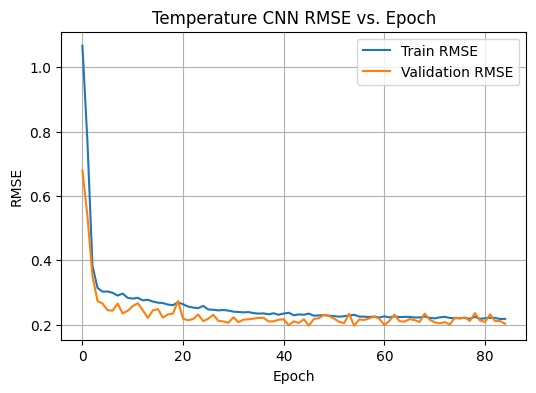

'\n'

In [14]:



val_scores_temp_non_diff = {}
val_scores_temp_diff = {}

best_temp_non_diff_name = None
best_temp_non_diff_lr = None
best_temp_non_diff_rmse = float('inf')

best_temp_diff_name = None
best_temp_diff_lr = None
best_temp_diff_rmse = float('inf')

# -------- non-diffusion temp: search over model × LR --------
for name, build_model in temp_candidates:
    for lr in TEMP_LRS:
        model = build_model().to(DEVICE)
        opt = torch.optim.Adam(model.parameters(), lr=lr)

        # short search training
        for _ in range(SEARCH_EPOCHS):
            train_epoch(model, loader_temp_train, opt, temp_loss)

        # validation RMSE
        val_rmse = evaluate_model(model, loader_temp_val, diffusion=False, out_channels=1)
        val_scores_temp_non_diff[(name, lr)] = val_rmse
        print(f"Temp non-diff {name}, lr={lr:g} VAL RMSE: {val_rmse:.4f}")

        if val_rmse < best_temp_non_diff_rmse:
            best_temp_non_diff_rmse = val_rmse
            best_temp_non_diff_name = name
            best_temp_non_diff_lr = lr


print("Best temp non-diffusion:",
      best_temp_non_diff_name,
      "lr=", best_temp_non_diff_lr,
      "RMSE=", best_temp_non_diff_rmse)

# -------- diffusion temp: search over model × LR --------
for name, build_model in temp_diff_candidates:
    for lr in TEMP_LRS:
        model = build_model().to(DEVICE)
        opt = torch.optim.Adam(model.parameters(), lr=lr)

        # train with diffusion_loss_temp
        for _ in range(SEARCH_EPOCHS):
            train_epoch_diffusion(model, loader_temp_train, opt, diffusion_loss_temp)

        # validate with RMSE on sampled predictions
        val_rmse = evaluate_model(model, loader_temp_val, diffusion=True, out_channels=1)
        val_scores_temp_diff[(name, lr)] = val_rmse
        print(f"Temp diffusion {name}, lr={lr:g} VAL RMSE: {val_rmse:.4f}")

        if val_rmse < best_temp_diff_rmse:
            best_temp_diff_rmse = val_rmse
            best_temp_diff_name = name
            best_temp_diff_lr = lr

print("Best temp diffusion:",
      best_temp_diff_name,
      "lr=", best_temp_diff_lr,
      "RMSE=", best_temp_diff_rmse)


# fresh models with best hyperparams
best_temp_non_diff = dict(temp_candidates)[best_temp_non_diff_name]().to(DEVICE)
best_temp_diff     = dict(temp_diff_candidates)[best_temp_diff_name]().to(DEVICE)


# final training: non-diff

train_rmse_hist_non_diff = [] 
val_rmse_hist_non_diff = []

init_train_rmse = evaluate_model(best_temp_non_diff, loader_temp_train,
                                 diffusion=False, out_channels=1)
init_val_rmse   = evaluate_model(best_temp_non_diff, loader_temp_val,
                                 diffusion=False, out_channels=1)

train_rmse_hist_non_diff.append(init_train_rmse)
val_rmse_hist_non_diff.append(init_val_rmse)

opt_non_diff = torch.optim.Adam(best_temp_non_diff.parameters(), lr=best_temp_non_diff_lr)

best_val = float('inf')
best_state = None
patience = 30              
bad_epochs = 0

for epoch in range(NUM_EPOCHS):
    avg_loss = train_epoch(best_temp_non_diff, loader_temp_train, opt_non_diff, temp_loss)

    train_rmse = evaluate_model(best_temp_non_diff, loader_temp_train,
                                diffusion=False, out_channels=1)
    val_rmse = evaluate_model(best_temp_non_diff, loader_temp_val,
                              diffusion=False, out_channels=1)

    train_rmse_hist_non_diff.append(train_rmse)
    val_rmse_hist_non_diff.append(val_rmse)

    print(f"Final temp non-diff epoch {epoch}, "
          f"loss {avg_loss:.4f}, train RMSE {train_rmse:.4f}, val RMSE {val_rmse:.4f}")

    if val_rmse < best_val - 1e-4:
        best_val = val_rmse
        best_state = best_temp_non_diff.state_dict()
        bad_epochs = 0
    else:
        bad_epochs += 1

    if bad_epochs >= patience:
        print(f"Early stopping at epoch {epoch}, best val RMSE = {best_val:.4f}")
        break

if best_state is not None:
    best_temp_non_diff.load_state_dict(best_state)
    print(f"Loaded best model with val RMSE = {best_val:.4f}")

import numpy as np

epochs = np.arange(len(train_rmse_hist_non_diff))

plt.figure(figsize=(6,4))
plt.plot(epochs, train_rmse_hist_non_diff, label="Train RMSE")
plt.plot(epochs, val_rmse_hist_non_diff, label="Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Temperature CNN RMSE vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

# final training: diffusion

train_rmse_hist_diff = []
val_rmse_hist_diff = []

opt_diff = torch.optim.Adam(best_temp_diff.parameters(), lr=best_temp_diff_lr)
for epoch in range(NUM_EPOCHS):
    avg_loss = train_epoch_diffusion(best_temp_diff, loader_temp_train, opt_diff, diffusion_loss_temp)

    train_rmse = evaluate_model(best_temp_diff, loader_temp_train,
                                diffusion=True, out_channels=1)
    val_rmse = evaluate_model(best_temp_diff, loader_temp_val,
                              diffusion=True, out_channels=1)

    train_rmse_hist_diff.append(train_rmse)
    val_rmse_hist_diff.append(val_rmse)

    print(f"Final temp diffusion epoch {epoch}, "
          f"loss {avg_loss:.4f}, train RMSE {train_rmse:.4f}, val RMSE {val_rmse:.4f}")

plt.figure(figsize=(6,4))
plt.plot(train_rmse_hist_diff, label="Train RMSE (diffusion)")
plt.plot(val_rmse_hist_diff, label="Validation RMSE (diffusion)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Temperature Diffusion RMSE vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

'''
'''


## 4. Vel → Vel models (divergence penalty)

Vel non-diff lstm32_1L, lr=0.0001, div_w=0, VAL RMSE: 1.1862
Vel non-diff lstm32_1L, lr=0.0001, div_w=0.001, VAL RMSE: 1.1946
Vel non-diff lstm32_1L, lr=0.0001, div_w=0.01, VAL RMSE: 1.1884
Vel non-diff lstm32_1L, lr=0.0003, div_w=0, VAL RMSE: 1.1705
Vel non-diff lstm32_1L, lr=0.0003, div_w=0.001, VAL RMSE: 1.1648
Vel non-diff lstm32_1L, lr=0.0003, div_w=0.01, VAL RMSE: 1.1881
Vel non-diff lstm32_1L, lr=0.001, div_w=0, VAL RMSE: 1.1814
Vel non-diff lstm32_1L, lr=0.001, div_w=0.001, VAL RMSE: 1.2160
Vel non-diff lstm32_1L, lr=0.001, div_w=0.01, VAL RMSE: 1.2071
Vel non-diff lstm32_2L, lr=0.0001, div_w=0, VAL RMSE: 1.1767
Vel non-diff lstm32_2L, lr=0.0001, div_w=0.001, VAL RMSE: 1.2066
Vel non-diff lstm32_2L, lr=0.0001, div_w=0.01, VAL RMSE: 1.2067
Vel non-diff lstm32_2L, lr=0.0003, div_w=0, VAL RMSE: 1.2286
Vel non-diff lstm32_2L, lr=0.0003, div_w=0.001, VAL RMSE: 1.1932
Vel non-diff lstm32_2L, lr=0.0003, div_w=0.01, VAL RMSE: 1.2019
Vel non-diff lstm32_2L, lr=0.001, div_w=0, VAL RMSE: 

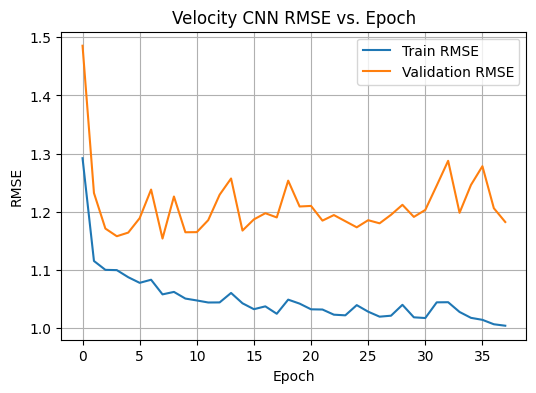

In [13]:


val_scores_vel_non_diff = {}
val_scores_vel_diff = {}

best_vel_non_diff_name = None
best_vel_non_diff_lr = None
best_vel_non_diff_div = None
best_vel_non_diff_rmse = float('inf')

best_vel_diff_name = None
best_vel_diff_lr = None
best_vel_diff_div = None
best_vel_diff_rmse = float('inf')

# -------- non-diffusion vel: search over model × LR × div_weight --------
for name, build_model in vel_candidates:
    for lr in VEL_LRS:
        for div_w in DIV_WEIGHTS:
            model = build_model().to(DEVICE)
            opt = torch.optim.Adam(model.parameters(), lr=lr)

            # hyperparam search training
            for _ in range(SEARCH_EPOCHS):
                train_epoch_vel(model, loader_vel_train, opt, div_w)

            # validation RMSE (non-diff)
            val_rmse = evaluate_model(model, loader_vel_val, diffusion=False, out_channels=2)
            val_scores_vel_non_diff[(name, lr, div_w)] = val_rmse
            print(f"Vel non-diff {name}, lr={lr:g}, div_w={div_w:g}, VAL RMSE: {val_rmse:.4f}")

            if val_rmse < best_vel_non_diff_rmse:
                best_vel_non_diff_rmse = val_rmse
                best_vel_non_diff_name = name
                best_vel_non_diff_lr = lr
                best_vel_non_diff_div = div_w

print(
    "Best vel non-diff:",
    best_vel_non_diff_name,
    "lr=", best_vel_non_diff_lr,
    "div_w=", best_vel_non_diff_div,
    "RMSE=", best_vel_non_diff_rmse,
)

# -------- diffusion vel: search over model × LR × div_weight --------
for name, build_model in vel_diff_candidates:
    for lr in VEL_LRS:
        for div_w in DIV_WEIGHTS:
            model = build_model().to(DEVICE)
            opt = torch.optim.Adam(model.parameters(), lr=lr)

            # hyperparam search training (diffusion)
            for _ in range(SEARCH_EPOCHS):
                train_epoch_diffusion_vel(model, loader_vel_train, opt, div_w)

            # validation RMSE (diffusion: sample then rmse)
            val_rmse = evaluate_model(model, loader_vel_val, diffusion=True, out_channels=2)
            val_scores_vel_diff[(name, lr, div_w)] = val_rmse
            print(f"Vel diffusion {name}, lr={lr:g}, div_w={div_w:g}, VAL RMSE: {val_rmse:.4f}")

            if val_rmse < best_vel_diff_rmse:
                best_vel_diff_rmse = val_rmse
                best_vel_diff_name = name
                best_vel_diff_lr = lr
                best_vel_diff_div = div_w

print(
    "Best vel diffusion:",
    best_vel_diff_name,
    "lr=", best_vel_diff_lr,
    "div_w=", best_vel_diff_div,
    "RMSE=", best_vel_diff_rmse,
)

best_vel_non_diff = dict(vel_candidates)[best_vel_non_diff_name]().to(DEVICE)
best_vel_diff     = dict(vel_diff_candidates)[vel_temp_diff_name]().to(DEVICE)


# ----- final non-diff vel training -----
best_vel_non_diff = dict(vel_candidates)[best_vel_non_diff_name]().to(DEVICE)
opt_vel_non_diff = torch.optim.Adam(best_vel_non_diff.parameters(), lr=best_vel_non_diff_lr)

train_rmse_hist_vel_non_diff = []
val_rmse_hist_vel_non_diff = []

init_train_rmse = evaluate_model(best_vel_non_diff, loader_vel_train,
                                 diffusion=False, out_channels=2)
init_val_rmse   = evaluate_model(best_vel_non_diff, loader_vel_val,
                                 diffusion=False, out_channels=2)
train_rmse_hist_vel_non_diff.append(init_train_rmse)
val_rmse_hist_vel_non_diff.append(init_val_rmse)

print(f"[Vel non-diff] Init train RMSE {init_train_rmse:.4f}, "
      f"init val RMSE {init_val_rmse:.4f}")

#early stoping
best_val = float('inf')
best_state = None
patience = 30
bad_epochs = 0

for epoch in range(NUM_EPOCHS):
    avg_loss = train_epoch_vel(best_vel_non_diff, loader_vel_train,
                               opt_vel_non_diff, best_vel_non_diff_div)
    
    train_rmse = evaluate_model(best_vel_non_diff, loader_vel_train,
                                diffusion=False, out_channels=2)
    val_rmse = evaluate_model(best_vel_non_diff, loader_vel_val,
                              diffusion=False, out_channels=2)

    train_rmse_hist_vel_non_diff.append(train_rmse)
    val_rmse_hist_vel_non_diff.append(val_rmse)

    print(f"Final vel non-diff epoch {epoch}, "
          f"loss {avg_loss:.4f}, train RMSE {train_rmse:.4f}, "
          f"val RMSE {val_rmse:.4f}")

    # updating early stopping
    if val_rmse < best_val - 1e-4:
        best_val = val_rmse
        best_state = best_vel_non_diff.state_dict()
        bad_epochs = 0
    else:
        bad_epochs += 1

    if bad_epochs >= patience:
        print(f"[Vel non-diff] Early stopping at epoch {epoch}, "
              f"best val RMSE = {best_val:.4f}")
        break

if best_state is not None:
    best_vel_non_diff.load_state_dict(best_state)
    print(f"[Vel non-diff] Loaded best model with val RMSE = {best_val:.4f}")

epochs_non_diff = np.arange(len(train_rmse_hist_vel_non_diff))

plt.figure(figsize=(6, 4))
plt.plot(epochs_non_diff, train_rmse_hist_vel_non_diff, label="Train RMSE")
plt.plot(epochs_non_diff, val_rmse_hist_vel_non_diff, label="Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Velocity CNN RMSE vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

# ----- final diffusion vel training -----
best_vel_diff = dict(vel_diff_candidates)[best_vel_diff_name]().to(DEVICE)
opt_vel_diff = torch.optim.Adam(best_vel_diff.parameters(), lr=best_vel_diff_lr)

train_rmse_hist_vel_diff = []
val_rmse_hist_vel_diff = []

for epoch in range(NUM_EPOCHS):
    avg_loss = train_epoch_diffusion_vel(best_vel_diff, loader_vel_train,
                                         opt_vel_diff, best_vel_diff_div)

    train_rmse = evaluate_model(best_vel_diff, loader_vel_train,
                                diffusion=True, out_channels=2)
    val_rmse = evaluate_model(best_vel_diff, loader_vel_val,
                              diffusion=True, out_channels=2)

    train_rmse_hist_vel_diff.append(train_rmse)
    val_rmse_hist_vel_diff.append(val_rmse)

    print(f"Final vel diffusion epoch {epoch}, "
          f"loss {avg_loss:.4f}, train RMSE {train_rmse:.4f}, "
          f"val RMSE {val_rmse:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(train_rmse_hist_vel_diff, label="Train RMSE (diffusion)")
plt.plot(val_rmse_hist_vel_diff, label="Validation RMSE (diffusion)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Velocity Diffusion RMSE vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

## 5. Prepare predicted velocities for temp + vel → temp

In [16]:

@torch.no_grad
def predict_velocities(model, loader, out_channels, diffusion=False):
    model.eval()
    outputs = []
    for xin, _ in loader:
        xin = xin.to(DEVICE)
        if diffusion:
            preds = diffusion_sample(model, xin, out_channels=out_channels)
        else:
            preds = model(xin)
        outputs.append(preds.cpu())
    return torch.cat(outputs, dim=0)

loader_vel_train_noshuffle = DataLoader(vel_train, batch_size=BATCH_SIZE, shuffle=False)

vel_pred_train_non_diff = predict_velocities(best_vel_non_diff, loader_vel_train_noshuffle, out_channels=2)
vel_pred_val_non_diff = predict_velocities(best_vel_non_diff, loader_vel_val, out_channels=2)
vel_pred_test_non_diff = predict_velocities(best_vel_non_diff, loader_vel_test, out_channels=2)

vel_pred_train_diff = predict_velocities(best_vel_diff, loader_vel_train_noshuffle, out_channels=2, diffusion=True)
vel_pred_val_diff = predict_velocities(best_vel_diff, loader_vel_val, out_channels=2, diffusion=True)
vel_pred_test_diff = predict_velocities(best_vel_diff, loader_vel_test, out_channels=2, diffusion=True)


def build_combined(temp_ds, vel_ds, vel_pred):
    inputs = []
    targets = []
    for (t_in, t_out), (v_in, _), v_pred in zip(temp_ds, vel_ds, vel_pred):
        cond = torch.cat([t_in, v_in, v_pred], dim=0)
        inputs.append(cond)
        targets.append(t_out)
    return TensorDataset(torch.stack(inputs), torch.stack(targets))

combined_train_non_diff = build_combined(temp_train, vel_train, vel_pred_train_non_diff)
combined_val_non_diff = build_combined(temp_val, vel_val, vel_pred_val_non_diff)
combined_test_non_diff = build_combined(temp_test, vel_test, vel_pred_test_non_diff)

combined_train_diff = build_combined(temp_train, vel_train, vel_pred_train_diff)
combined_val_diff = build_combined(temp_val, vel_val, vel_pred_val_diff)
combined_test_diff = build_combined(temp_test, vel_test, vel_pred_test_diff)

loader_comb_train_non_diff = DataLoader(combined_train_non_diff, batch_size=BATCH_SIZE, shuffle=True)
loader_comb_val_non_diff = DataLoader(combined_val_non_diff, batch_size=BATCH_SIZE)
loader_comb_test_non_diff = DataLoader(combined_test_non_diff, batch_size=BATCH_SIZE)

loader_comb_train_diff = DataLoader(combined_train_diff, batch_size=BATCH_SIZE, shuffle=True)
loader_comb_val_diff = DataLoader(combined_val_diff, batch_size=BATCH_SIZE)
loader_comb_test_diff = DataLoader(combined_test_diff, batch_size=BATCH_SIZE)


## 6. Temp + vel → temp models and advection baseline

Combined non-diff cnn24, lr=0.0001 VAL RMSE: 0.2207
Combined non-diff cnn24, lr=0.0003 VAL RMSE: 0.2361
Combined non-diff cnn24, lr=0.001 VAL RMSE: 0.2323
Combined non-diff cnn48, lr=0.0001 VAL RMSE: 0.2073
Combined non-diff cnn48, lr=0.0003 VAL RMSE: 0.2351
Combined non-diff cnn48, lr=0.001 VAL RMSE: 0.2502
Combined non-diff cnn96, lr=0.0001 VAL RMSE: 0.2290
Combined non-diff cnn96, lr=0.0003 VAL RMSE: 0.2322
Combined non-diff cnn96, lr=0.001 VAL RMSE: 0.2274
Combined non-diff lstm96, lr=0.0001 VAL RMSE: 0.2525
Combined non-diff lstm96, lr=0.0003 VAL RMSE: 0.2070
Combined non-diff lstm96, lr=0.001 VAL RMSE: 0.2333
Best combined non-diffusion: lstm96 lr= 0.0003 RMSE= 0.20703961100520157
[Comb non-diff] Init train RMSE 1.0509, init val RMSE 0.6770
[Comb non-diff] epoch 0, loss 2.1623, train RMSE 0.3599, val RMSE 0.4111
[Comb non-diff] epoch 1, loss 0.4241, train RMSE 0.3029, val RMSE 0.2634
[Comb non-diff] epoch 2, loss 0.3711, train RMSE 0.2804, val RMSE 0.2515
[Comb non-diff] epoch 3,

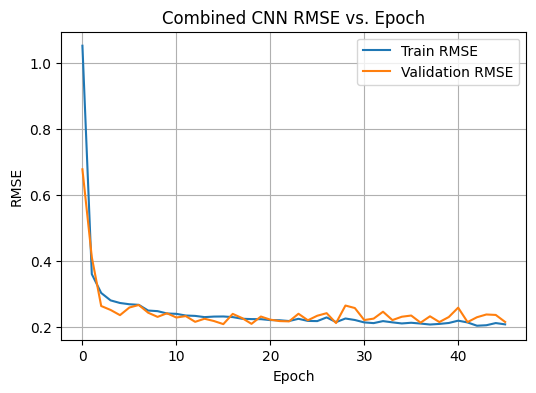

In [18]:

val_scores_comb_non_diff = {}
val_scores_comb_diff = {}

best_comb_non_diff_name = None
best_comb_non_diff_lr = None
best_comb_non_diff_rmse = float('inf')

best_comb_diff_name = None
best_comb_diff_lr = None
best_comb_diff_rmse = float('inf')

# -------- non-diffusion combined: search over model × LR --------
for name, build_model in comb_candidates:
    for lr in COMB_LRS:
        model = build_model().to(DEVICE)
        opt = torch.optim.Adam(model.parameters(), lr=lr)

        # hyperparam search training (non-diff combined)
        for _ in range(SEARCH_EPOCHS):
            train_epoch(model, loader_comb_train_non_diff, opt, temp_loss)

        # validation RMSE (non-diff combined)
        val_rmse = evaluate_model(
            model,
            loader_comb_val_non_diff,
            diffusion=False,
            out_channels=1,
        )
        val_scores_comb_non_diff[(name, lr)] = val_rmse
        print(f"Combined non-diff {name}, lr={lr:g} VAL RMSE: {val_rmse:.4f}")

        if val_rmse < best_comb_non_diff_rmse:
            best_comb_non_diff_rmse = val_rmse
            best_comb_non_diff_name = name
            best_comb_non_diff_lr = lr

print(
    "Best combined non-diffusion:",
    best_comb_non_diff_name,
    "lr=", best_comb_non_diff_lr,
    "RMSE=", best_comb_non_diff_rmse,
)

# -------- diffusion combined: search over model × LR --------
for name, build_model in comb_diff_candidates:
    for lr in COMB_LRS:
        model = build_model().to(DEVICE)
        opt = torch.optim.Adam(model.parameters(), lr=lr)

        # hyperparam search training (diffusion combined)
        for _ in range(SEARCH_EPOCHS):
            train_epoch_diffusion(model, loader_comb_train_diff, opt, diffusion_loss_temp)

        # validation RMSE (diffusion combined)
        val_rmse = evaluate_model(model, loader_comb_val_diff, diffusion=True, out_channels=1)
        val_scores_comb_diff[(name, lr)] = val_rmse
        print(f"Combined diffusion {name}, lr={lr:g} VAL RMSE: {val_rmse:.4f}")

        if val_rmse < best_comb_diff_rmse:
            best_comb_diff_rmse = val_rmse
            best_comb_diff_name = name
            best_comb_diff_lr = lr

print(
    "Best combined diffusion:",
    best_comb_diff_name,
    "lr=", best_comb_diff_lr,
    "RMSE=", best_comb_diff_rmse,
)

# -------- final training of chosen combined models for NUM_EPOCHS --------


# fresh best non-diff combined model
best_comb_non_diff = dict(comb_candidates)[best_comb_non_diff_name]().to(DEVICE)
opt_comb_non_diff = torch.optim.Adam(best_comb_non_diff.parameters(), lr=best_comb_non_diff_lr)

train_rmse_hist_comb_non_diff = []
val_rmse_hist_comb_non_diff = []

#initial RMSE
init_train_rmse = evaluate_model(
    best_comb_non_diff,
    loader_comb_train_non_diff,
    diffusion=False,
    out_channels=1,
)
init_val_rmse = evaluate_model(
    best_comb_non_diff,
    loader_comb_val_non_diff,
    diffusion=False,
    out_channels=1,
)

train_rmse_hist_comb_non_diff.append(init_train_rmse)
val_rmse_hist_comb_non_diff.append(init_val_rmse)

print(f"[Comb non-diff] Init train RMSE {init_train_rmse:.4f}, "
      f"init val RMSE {init_val_rmse:.4f}")

#early stopping
best_val = float('inf')
best_state = None
patience = 30
bad_epochs = 0


for epoch in range(NUM_EPOCHS):
    avg_loss = train_epoch(
        best_comb_non_diff,
        loader_comb_train_non_diff,
        opt_comb_non_diff,
        temp_loss,
    )

    train_rmse = evaluate_model(
        best_comb_non_diff,
        loader_comb_train_non_diff,
        diffusion=False,
        out_channels=1,
    )
    val_rmse = evaluate_model(
        best_comb_non_diff,
        loader_comb_val_non_diff,
        diffusion=False,
        out_channels=1,
    )

    train_rmse_hist_comb_non_diff.append(train_rmse)
    val_rmse_hist_comb_non_diff.append(val_rmse)

    print(f"[Comb non-diff] epoch {epoch}, "
          f"loss {avg_loss:.4f}, train RMSE {train_rmse:.4f}, "
          f"val RMSE {val_rmse:.4f}")

    # updating early stopping
    if val_rmse < best_val - 1e-4:
        best_val = val_rmse
        best_state = best_comb_non_diff.state_dict()
        bad_epochs = 0
    else:
        bad_epochs += 1

    if bad_epochs >= patience:
        print(f"[Comb non-diff] Early stopping at epoch {epoch}, "
              f"best val RMSE = {best_val:.4f}")
        break

if best_state is not None:
    best_comb_non_diff.load_state_dict(best_state)
    print(f"[Comb non-diff] Loaded best model with val RMSE = {best_val:.4f}")


import numpy as np

epochs_comb = np.arange(len(train_rmse_hist_comb_non_diff))

plt.figure(figsize=(6, 4))
plt.plot(epochs_comb, train_rmse_hist_comb_non_diff, label="Train RMSE")
plt.plot(epochs_comb, val_rmse_hist_comb_non_diff, label="Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Combined CNN RMSE vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

# fresh best diffusion combined model
best_comb_diff = dict(comb_diff_candidates)[best_comb_diff_name]().to(DEVICE)
opt_comb_diff = torch.optim.Adam(best_comb_diff.parameters(), lr=best_comb_diff_lr)


train_rmse_hist_comb_diff = []
val_rmse_hist_comb_diff = []

for epoch in range(NUM_EPOCHS):
    avg_loss = train_epoch_diffusion(best_comb_diff, loader_comb_train_diff,
                                     opt_comb_diff, diffusion_loss_temp)

    train_rmse = evaluate_model(best_comb_diff, loader_comb_train_diff,
                                diffusion=True, out_channels=1)
    val_rmse = evaluate_model(best_comb_diff, loader_comb_val_diff,
                              diffusion=True, out_channels=1)

    train_rmse_hist_comb_diff.append(train_rmse)
    val_rmse_hist_comb_diff.append(val_rmse)

    print(f"Final combined diffusion epoch {epoch}, "
          f"loss {avg_loss:.4f}, train RMSE {train_rmse:.4f}, "
          f"val RMSE {val_rmse:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(train_rmse_hist_comb_diff, label="Train RMSE (diffusion)")
plt.plot(val_rmse_hist_comb_diff, label="Validation RMSE (diffusion)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Combined Diffusion RMSE vs. Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# temp models
temp_rmse_non_diff = evaluate_model(best_temp_non_diff, loader_temp_test)
temp_rmse_diff = evaluate_model(best_temp_diff, loader_temp_test, diffusion=True, out_channels=1)

# vel models
vel_rmse_non_diff = evaluate_model(best_vel_non_diff, loader_vel_test)
vel_rmse_diff = evaluate_model(best_vel_diff, loader_vel_test, diffusion=True, out_channels=2)

# combined models
comb_rmse_non_diff = evaluate_model(best_comb_non_diff, loader_comb_test_non_diff)
comb_rmse_diff = evaluate_model(best_comb_diff, loader_comb_test_diff, diffusion=True, out_channels=1)

def advection_step(temp, vel_now, vel_next, dt=ADVECTION_DT, kappa=DIFFUSIVITY):
    """
    One explicit advection–diffusion step for temperature.

    Inputs:
      temp     : (1, H, W)   temperature at time t
      vel_now  : (2, H, W)   velocity at time t      (u_now, v_now)
      vel_next : (2, H, W)   velocity at time t+Δt   (u_next, v_next)
      dt       : time step (ADVECTION_DT)
      kappa    : diffusivity constant (DIFFUSIVITY)

    Returns:
      temp_next: (1, H, W)   updated temperature field after one step
    """
    # unpack velocities into components
    u_now, v_now = vel_now        # each (H, W)
    u_next, v_next = vel_next

    # midpoint velocity for semi-implicit advection
    u_mid = 0.5 * (u_now + u_next)
    v_mid = 0.5 * (v_now + v_next)

    # spatial gradients of temperature (central differences)
    dTdx = torch.zeros_like(temp)
    dTdy = torch.zeros_like(temp)

    # temp is (1, H, W): index last two dims for space
    dTdx[:, :, 1:-1] = (temp[:, :, 2:] - temp[:, :, :-2]) * 0.5
    dTdy[:, 1:-1, :] = (temp[:, 2:, :] - temp[:, :-2, :]) * 0.5

    # Laplacian of temperature for diffusion term
    lap = torch.zeros_like(temp)
    lap[:, :, 1:-1] = temp[:, :, 2:] - 2 * temp[:, :, 1:-1] + temp[:, :, :-2]
    lap[:, 1:-1, :] += temp[:, 2:, :] - 2 * temp[:, 1:-1, :] + temp[:, :-2, :]

    # advection term: -(u · ∇T)
    adv = - (u_mid.unsqueeze(0) * dTdx + v_mid.unsqueeze(0) * dTdy)

    # diffusion term: κ ∇²T
    diff_term = kappa * lap

    # explicit Euler update
    return temp + dt * (adv + diff_term)


@torch.no_grad
def evaluate_advection(temp_ds, vel_ds, vel_pred):
    """
    temp_ds items: (t_in, t_out)
        t_in:  (2, H, W)   = [temp(t-1), temp(t)]
        t_out: (1, H, W)   = temp(t+H)

    vel_ds items: (v_in, v_out)
        v_in:  (2, H, W)   = [u(t), v(t)]
        v_out: (2, H, W)   = [u(t+H), v(t+H)]  (unused here)

    vel_pred: tensor of predicted vel(t+H), shape (N, 2, H, W)
    """
    rmses = []
    for (t_in, t_out), (v_in, _), v_next in zip(temp_ds, vel_ds, vel_pred):
        # t_in is (2, H, W): take the *current* snapshot temp(t) as input to advection
        temp_now = t_in[1:2].to(DEVICE)      # (1, H, W)

        v_in = v_in.to(DEVICE)               # (2, H, W)  = [u(t), v(t)]
        v_next = v_next.to(DEVICE)           # (2, H, W)  = predicted [u(t+H), v(t+H)]

        # advection_step expects (1, H, W), (2, H, W), (2, H, W)
        adv = advection_step(temp_now, v_in, v_next)   # (1, H, W)

        # rmse expects (B, C, H, W), so add batch dim
        rmses.append(rmse(adv.unsqueeze(0), t_out.unsqueeze(0)))
    return sum(rmses) / len(rmses)

adv_rmse = evaluate_advection(temp_test, vel_test, vel_pred_test_non_diff)

@torch.no_grad
def evaluate_persistence(temp_loader):
    """
    Baseline: predict temp(t+H) ≈ temp(t).
    temp_loader yields (t_in, t_out) with:
        t_in:  (B, 2, H, W) = [temp(t-1), temp(t)]
        t_out: (B, 1, H, W) = temp(t+H)
    """
    rmses = []
    for t_in, t_out in temp_loader:
        # use only the current snapshot temp(t)
        t_in_cur = t_in[:, 1:2].to(DEVICE)   # (B, 1, H, W)
        t_out = t_out.to(DEVICE)            # (B, 1, H, W)
        rmses.append(rmse(t_in_cur, t_out))
    return sum(rmses) / len(rmses)

persistence_rmse = evaluate_persistence(loader_temp_test)


print('Temp non-diff RMSE', temp_rmse_non_diff)
print('Temp diffusion RMSE', temp_rmse_diff)
print('Vel non-diff RMSE', vel_rmse_non_diff)
print('Vel diffusion RMSE', vel_rmse_diff)
print('Combined non-diff RMSE', comb_rmse_non_diff)
print('Combined diffusion RMSE', comb_rmse_diff)
print('Advection baseline RMSE', adv_rmse)
print("Persistence baseline RMSE:", persistence_rmse)


NameError: name 'best_temp_diff' is not defined

## 7. Evaluation and comparisons

### Comparison summary

In [19]:

summary = {
    'temp_non_diff': temp_rmse_non_diff,
    'temp_diffusion': temp_rmse_diff,
    'vel_non_diff': vel_rmse_non_diff,
    'vel_diffusion': vel_rmse_diff,
    'comb_non_diff': comb_rmse_non_diff,
    'comb_diffusion': comb_rmse_diff,
    'advection': adv_rmse
}
summary


NameError: name 'temp_rmse_non_diff' is not defined

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Pick an example index
idx = 0  # change if you want a different sample

VALID_MASK_2D = VALID_MASK[0, 0].cpu().numpy().astype(bool)


def temp_to_2d(arr):
    """
    arr: (H, W) or (1, H, W) or (2, H, W)
    Returns a numpy 2D array with land masked as NaN.
    For multi-channel arr, pass arr[c] explicitly.
    """
    if arr.ndim == 3 and arr.shape[0] == 1:
        arr2 = arr[0]
    else:
        arr2 = arr
    arr2 = arr2.copy()
    arr2[~VALID_MASK_2D] = np.nan
    return arr2


def plot_temp(ax, field_2d, title):
    im = ax.imshow(field_2d, origin='lower', cmap='viridis')
    ax.set_title(title)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


def vel_to_rgb(vel):
    """
    vel: (2, H, W) numpy array (u, v)
    Returns an RGB image where:
      R ~ u, B ~ v, G = 0, land = gray.
    Normalizes u and v separately to [0,1].
    """
    u = vel[0]
    v = vel[1]

    u_min, u_max = u.min(), u.max()
    v_min, v_max = v.min(), v.max()
    u_norm = (u - u_min) / (u_max - u_min + 1e-8)
    v_norm = (v - v_min) / (v_max - v_min + 1e-8)

    H, W = u.shape
    rgb = np.zeros((H, W, 3), dtype=np.float32)
    rgb[..., 0] = u_norm   # red = u
    rgb[..., 2] = v_norm   # blue = v

    # land = gray
    rgb[~VALID_MASK_2D] = 0.5
    return rgb


def plot_vel(ax, vel, title):
    """
    vel: (2, H, W) numpy array
    """
    rgb = vel_to_rgb(vel)
    ax.imshow(rgb, origin='lower')
    ax.set_title(title)
    ax.axis('off')


with torch.no_grad():
    # ===================== TEMP MODELS =====================
    temp_in, temp_out = temp_test[idx]   # temp_in: (2,H,W), temp_out: (1,H,W)
    temp_in_batch = temp_in.unsqueeze(0).to(DEVICE)
    temp_out_batch = temp_out.unsqueeze(0).to(DEVICE)

    best_temp_non_diff.eval()
    best_temp_diff.eval()

    temp_pred_non_diff = best_temp_non_diff(temp_in_batch).cpu().squeeze(0).numpy()  # (1,H,W)
    temp_pred_diff = diffusion_sample(best_temp_diff, temp_in_batch, out_channels=1).cpu().squeeze(0).numpy()

    temp_in_np = temp_in.numpy()      # (2,H,W)
    temp_out_np = temp_out.numpy()    # (1,H,W)

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle(f"Temp models example idx={idx}", fontsize=14)

    # Use current snapshot temp(t) = channel 1
    plot_temp(axes[0, 0], temp_to_2d(temp_in_np[1]), "Input temp(t)")
    plot_temp(axes[0, 1], temp_to_2d(temp_out_np[0]), "Target temp(t+H)")
    plot_temp(axes[0, 2], temp_to_2d(temp_pred_non_diff[0]), "Pred non-diff")

    plot_temp(axes[1, 0], temp_to_2d(temp_in_np[1]), "Input temp(t)")
    plot_temp(axes[1, 1], temp_to_2d(temp_out_np[0]), "Target temp(t+H)")
    plot_temp(axes[1, 2], temp_to_2d(temp_pred_diff[0]), "Pred diffusion")

    plt.tight_layout()
    plt.show()

    # ===================== VEL MODELS =====================
    vel_in, vel_out = vel_test[idx]   # (2,H,W), (2,H,W)
    vel_in_batch = vel_in.unsqueeze(0).to(DEVICE)
    vel_out_np = vel_out.numpy()

    best_vel_non_diff.eval()
    best_vel_diff.eval()

    vel_pred_non_diff = best_vel_non_diff(vel_in_batch).cpu().squeeze(0).numpy()  # (2,H,W)
    vel_pred_diff = diffusion_sample(best_vel_diff, vel_in_batch, out_channels=2).cpu().squeeze(0).numpy()

    vel_in_np = vel_in.numpy()  # (2,H,W)

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle(f"Vel models example idx={idx}", fontsize=14)

    # row 0: non-diff, row 1: diff
    plot_vel(axes[0, 0], vel_in_np, "Input vel(t)")
    plot_vel(axes[0, 1], vel_out_np, "Target vel(t+H)")
    plot_vel(axes[0, 2], vel_pred_non_diff, "Pred non-diff")

    plot_vel(axes[1, 0], vel_in_np, "Input vel(t)")
    plot_vel(axes[1, 1], vel_out_np, "Target vel(t+H)")
    plot_vel(axes[1, 2], vel_pred_diff, "Pred diffusion")

    plt.tight_layout()
    plt.show()

    # ===================== COMBINED TEMP MODELS =====================
    # combined_test_non_diff input has channels:
    # [temp(t-1), temp(t), u(t), v(t), u_pred(t+H), v_pred(t+H)]
    comb_in_non_diff, comb_out = combined_test_non_diff[idx]    # (6,H,W), (1,H,W)
    comb_in_diff, _ = combined_test_diff[idx]                   # (6,H,W), (1,H,W)

    comb_in_non_diff_batch = comb_in_non_diff.unsqueeze(0).to(DEVICE)
    comb_in_diff_batch = comb_in_diff.unsqueeze(0).to(DEVICE)
    comb_out_np = comb_out.numpy()  # (1,H,W)

    best_comb_non_diff.eval()
    best_comb_diff.eval()

    comb_pred_non_diff = best_comb_non_diff(comb_in_non_diff_batch).cpu().squeeze(0).numpy()  # (1,H,W)
    comb_pred_diff = diffusion_sample(best_comb_diff, comb_in_diff_batch, out_channels=1).cpu().squeeze(0).numpy()

    comb_in_non_diff_np = comb_in_non_diff.numpy()  # (6,H,W)
    temp_t_from_comb = comb_in_non_diff_np[1]       # temp(t)

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle(f"Combined temp models example idx={idx}", fontsize=14)

    plot_temp(axes[0, 0], temp_to_2d(temp_t_from_comb), "Input temp(t) (combined)")
    plot_temp(axes[0, 1], temp_to_2d(comb_out_np[0]), "Target temp(t+H)")
    plot_temp(axes[0, 2], temp_to_2d(comb_pred_non_diff[0]), "Pred combined non-diff")

    plot_temp(axes[1, 0], temp_to_2d(temp_t_from_comb), "Input temp(t) (combined)")
    plot_temp(axes[1, 1], temp_to_2d(comb_out_np[0]), "Target temp(t+H)")
    plot_temp(axes[1, 2], temp_to_2d(comb_pred_diff[0]), "Pred combined diffusion")

    plt.tight_layout()
    plt.show()

    # ===================== ADVECTION BASELINE =====================
    # Use same sample idx and non-diff vel prediction vel_pred_test_non_diff[idx]
    t_in_temp, t_out_temp = temp_test[idx]   # (2,H,W), (1,H,W)
    v_in, _ = vel_test[idx]                  # (2,H,W), (2,H,W)
    v_next = vel_pred_test_non_diff[idx]     # (2,H,W) predicted vel(t+H)

    temp_now = t_in_temp[1:2].to(DEVICE)     # use current snapshot temp(t), shape (1,H,W)
    v_in_dev = v_in.to(DEVICE)
    v_next_dev = v_next.to(DEVICE)

    adv_pred = advection_step(temp_now, v_in_dev, v_next_dev)  # (1,H,W)
    adv_pred_np = adv_pred.cpu().numpy()                       # (1,H,W)
    t_out_temp_np = t_out_temp.numpy()                         # (1,H,W)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f"Advection baseline example idx={idx}", fontsize=14)

    plot_temp(axes[0], temp_to_2d(temp_in_np[1]), "Input temp(t)")
    plot_temp(axes[1], temp_to_2d(t_out_temp_np[0]), "Target temp(t+H)")
    plot_temp(axes[2], temp_to_2d(adv_pred_np[0]), "Pred advection baseline")

    plt.tight_layout()
    plt.show()
